In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# Paths to your images
image_path_left = '../maritime_horizon_detection_brightness_eq-1/data/cam1_0.jpg'
image_path_right = '../maritime_horizon_detection_brightness_eq-1/data/cam2_0.jpg'

# image_path_left = '../maritime_horizon_detection_brightness_eq-1/data/cam1_9.jpg'
# image_path_right = '../maritime_horizon_detection_brightness_eq-1/data/cam2_9.jpg'

# image_path_left = '../maritime_horizon_detection_brightness_eq-1/data/cam1_3.jpg'
# image_path_right = '../maritime_horizon_detection_brightness_eq-1/data/cam2_3.jpg'

# image_path_left = '../maritime_horizon_detection_brightness_eq-1/data/cam1_12.jpg'
# image_path_right = '../maritime_horizon_detection_brightness_eq-1/data/cam2_12.jpg'

# image_path_left = '../maritime_horizon_detection_brightness_eq-1/data/test_cam1.png'
# image_path_right = '../maritime_horizon_detection_brightness_eq-1/data/test_cam2.png'

# image_path_left = '../maritime_horizon_detection_brightness_eq-1/data/test2.png'
# image_path_right = '../maritime_horizon_detection_brightness_eq-1/data/test3.png'

# image_path_left = '../maritime_horizon_detection_brightness_eq-1/data/test_cam1_ex1.png'
# image_path_right = '../maritime_horizon_detection_brightness_eq-1/data/test_cam2_ex1.png'

In [4]:
def horizon_detection(image_path):
    def process_image(image_path):
        # Load an image from file
        image = cv2.imread(image_path)
        
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray, 5)
        
        # Get dimensions of the image
        height, width = gray.shape
        
        # Define the height and starting y-coordinate of the region of interest (ROI)
        roi_height = int(height * 0.2)  # Using 20% of the total height
        roi_y_start = int(height * 0.3)  # Starting at 30% of the total height
        
        # Crop the region of interest from the grayscale image
        roi = gray[roi_y_start:roi_y_start + roi_height, :]
        
        # Apply Canny edge detection on the ROI
        edges = cv2.Canny(roi, 50, 150, apertureSize=3)
        
        # Detect lines using the Hough Transform on the edges detected within the ROI
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
        
        if lines is not None:
            longest_line = find_longest_line(lines)
            if longest_line is not None:
                return draw_line(image, longest_line, roi_y_start)
        
        return image, None  # Return the original image if no lines are detected

    @jit(nopython=True)
    def find_longest_line(lines):
        def line_length(line):
            x1, y1, x2, y2 = line[0]
            return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        max_length = 0
        longest_line = None

        for line in lines:
            length = line_length(line)
            if length > max_length:
                max_length = length
                longest_line = line

        return longest_line

    def draw_line(image, line, roi_y_start):
        x1, y1, x2, y2 = line[0]
        y1 += roi_y_start  # Adjust for ROI's vertical start position
        y2 += roi_y_start  # Adjust for ROI's vertical start position

        height, width = image.shape[:2]

        # Calculate the slope and intercept for the line
        if x2 != x1:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1

            # Determine the endpoints of the line to draw across the full image width
            x_start = 0
            y_start = int(intercept)
            x_end = width
            y_end = int(slope * x_end + intercept)
        else:
            # Handle the special case of a vertical line
            x_start, x_end = x1, x1
            y_start, y_end = 0, height

        # Draw the extrapolated line across the image
        cv2.line(image, (x_start, y_start), (x_end, y_end), (0, 0, 255), 2)

        return image, (x_start, y_start, x_end, y_end)

    return process_image(image_path)

def calculate_average_brightness(image, mask):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    _, _, v = cv2.split(hsv)
    masked_v = cv2.bitwise_and(v, v, mask=mask)
    return cv2.mean(masked_v, mask=mask)[0]

def adjust_brightness(image, mask, target_brightness):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    masked_v = cv2.bitwise_and(v, v, mask=mask)
    current_brightness = cv2.mean(masked_v, mask=mask)[0]
    
    if current_brightness == 0:
        return image  # Prevent division by zero

    adjustment_factor = target_brightness / current_brightness
    v = np.clip(v * adjustment_factor, 0, 255).astype(np.uint8)
    
    hsv_adjusted = cv2.merge([h, s, v])
    img_adjusted = cv2.cvtColor(hsv_adjusted, cv2.COLOR_HSV2BGR)
    
    adjusted_image = np.copy(image)
    adjusted_image[mask == 255] = img_adjusted[mask == 255]
    
    return adjusted_image

def process_sections(image, line_coords):
    height, width = image.shape[:2]
    x_start, y_start, x_end, y_end = line_coords
    
    if x_end != x_start:
        slope = (y_end - y_start) / (x_end - x_start)
        intercept = y_start - slope * x_start
    else:
        slope = float('inf')
        intercept = y_start

    mask_top = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    mask_bottom = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    
    for x in range(width):
        y = int(slope * x + intercept)
        if y >= 0 and y < height:
            mask_top[:y, x] = 255
            mask_bottom[y:, x] = 255

    top_part = cv2.bitwise_and(image, image, mask=mask_top)
    bottom_part = cv2.bitwise_and(image, image, mask=mask_bottom)

    return top_part, bottom_part, mask_top, mask_bottom


# Detect horizon and process the images
processed_left, line_coords_left = horizon_detection(image_path_left)
processed_right, line_coords_right = horizon_detection(image_path_right)

# Process top and bottom parts of the images
top_left, bottom_left, mask_top_left, mask_bottom_left = process_sections(processed_left, line_coords_left)
top_right, bottom_right, mask_top_right, mask_bottom_right = process_sections(processed_right, line_coords_right)

# Calculate average brightness
avg_brightness_top_left = calculate_average_brightness(processed_left, mask_top_left)
avg_brightness_top_right = calculate_average_brightness(processed_right, mask_top_right)
avg_brightness_bottom_left = calculate_average_brightness(processed_left, mask_bottom_left)
avg_brightness_bottom_right = calculate_average_brightness(processed_right, mask_bottom_right)

# Calculate target brightness as the average of corresponding sections
target_brightness_top = (avg_brightness_top_left + avg_brightness_top_right) / 2
target_brightness_bottom = (avg_brightness_bottom_left + avg_brightness_bottom_right) / 2

# Adjust brightness to match the target brightness
processed_left = adjust_brightness(processed_left, mask_top_left, target_brightness_top)
processed_left = adjust_brightness(processed_left, mask_bottom_left, target_brightness_bottom)
processed_right = adjust_brightness(processed_right, mask_top_right, target_brightness_top)
processed_right = adjust_brightness(processed_right, mask_bottom_right, target_brightness_bottom)

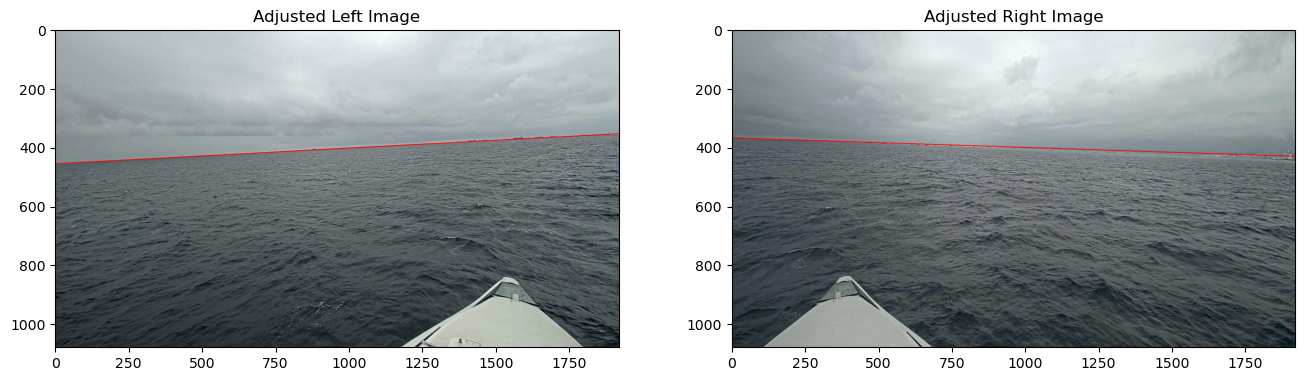

In [5]:
# Display the original and adjusted images
f, axarr = plt.subplots(1, 2, figsize=(16, 8))
axarr[0].imshow(cv2.cvtColor(processed_left, cv2.COLOR_BGR2RGB))
axarr[0].set_title('Adjusted Left Image')
axarr[1].imshow(cv2.cvtColor(processed_right, cv2.COLOR_BGR2RGB))
axarr[1].set_title('Adjusted Right Image')
plt.show()

Text(0.5, 1.0, 'Original Right Image')

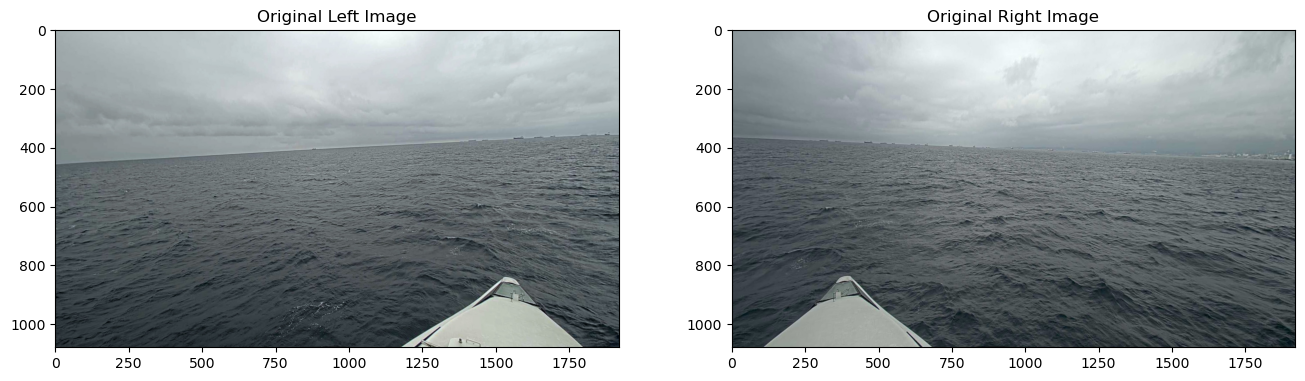

In [6]:
original_left = cv2.imread(image_path_left)
original_right = cv2.imread(image_path_right)

f, axarr = plt.subplots(1, 2, figsize=(16, 8))
axarr[0].imshow(cv2.cvtColor(original_left, cv2.COLOR_BGR2RGB))
axarr[0].set_title('Original Left Image')


axarr[1].imshow(cv2.cvtColor(original_right, cv2.COLOR_BGR2RGB))
axarr[1].set_title('Original Right Image')

